# CMIP6/Google API Tutorial
#### This file uses the Google API and CMIP6 data archive to load a selection of data and plot. Modifications can be made to what variable and experiment to load.

#### The setup of this file is based off of a number of online tutorials related to the Pangeo and XMIP projects, particularly:
* https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html
* https://pangeo.io/quickstart.html#quickstart
* https://intake-esm.readthedocs.io/en/latest/tutorials/loading-cmip6-data.html
* http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/intake_ESM_example.html
* https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html

#### Other possible location of CMIP6 data: https://esgf-node.llnl.gov

#### Some information on CMIP6 experiments:
* https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html

#### Recommend setting up a conda environment for installing the various libraries needed to load CMIP6 data.
* https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html

In [1]:
#%% Load the basic plotting functions and define a few of our own helper functions
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib
import cartopy.feature as cf
import numpy as np
import xarray as xr
from scipy.stats import gaussian_kde

import os
import sys

# Define our machine's home directory
MACHDIR = os.path.expanduser("~")
HOMEREPO = '/dev/CMIP'
sys.path.append(MACHDIR + HOMEREPO + '/')


def datetime_from_timestep(timearray,step = 'M',refdate='1901-01-01'):

    timesince = np.array([np.timedelta64(int(s), step) for s in timearray])
    
    cbftime = np.datetime64(refdate,step) + timesince
    cbftimens = np.array([np.datetime64(ts,'ns') for ts in cbftime])
    
    return cbftimens  

def latlon_latlonpcolor(lat,lon):
    # extend longitude by 2
    lon_extend = np.zeros(lon.size+2)
    # fill in internal values
    lon_extend[1:-1] = lon # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lon[0]-np.diff(lon)[0]
    lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))
    
    # extend latitude by 2
    lat_extend = np.zeros(lat.size+2)
    # fill in internal values
    lat_extend[1:-1] = lat
    # fill in extra endpoints
    lat_extend[0] = lat[0]-np.diff(lat)[0]
    lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
    
    return lat_pcolormesh_midpoints, lon_pcolormesh_midpoints

In [2]:
# Import key modules to interact with google api
import intake
import dask
from xmip.preprocessing import combined_preprocessing

#%%
def helper_func(ds):
    """Rename `olevel` dim to `lev`"""
    ds = ds.copy()
    # a short example
    ds = ds.squeeze()
    if "dcpp_init_year" in ds.dims:
        ds = ds.drop('dcpp_init_year')
    return ds


### Load the google api library

In [3]:

url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)


### Pick the variable and experiment to load

#### Define a region of interest

In [6]:

# Load models

#
##Define modules varialbes to load and region to select
varload = 'gpp'
expts = ['ssp370']#['historical', 'ssp245', 'ssp370','ssp585']#['piControl']

# Box region
latbound = [25.375, 49.375] #
lonbound = [-124.625, -67.125] #



#%% load a few models to illustrate the problem
query = dict(experiment_id=expts, table_id='Lmon',
              variable_id=varload, grid_label=['gn', 'gr']
            )
cat = col.search(**query)

cat.df['source_id'].unique()
z_kwargs = {'consolidated': True, 'decode_times':False}
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dset_dict = cat.to_dataset_dict(xarray_open_kwargs=z_kwargs, preprocess=helper_func)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


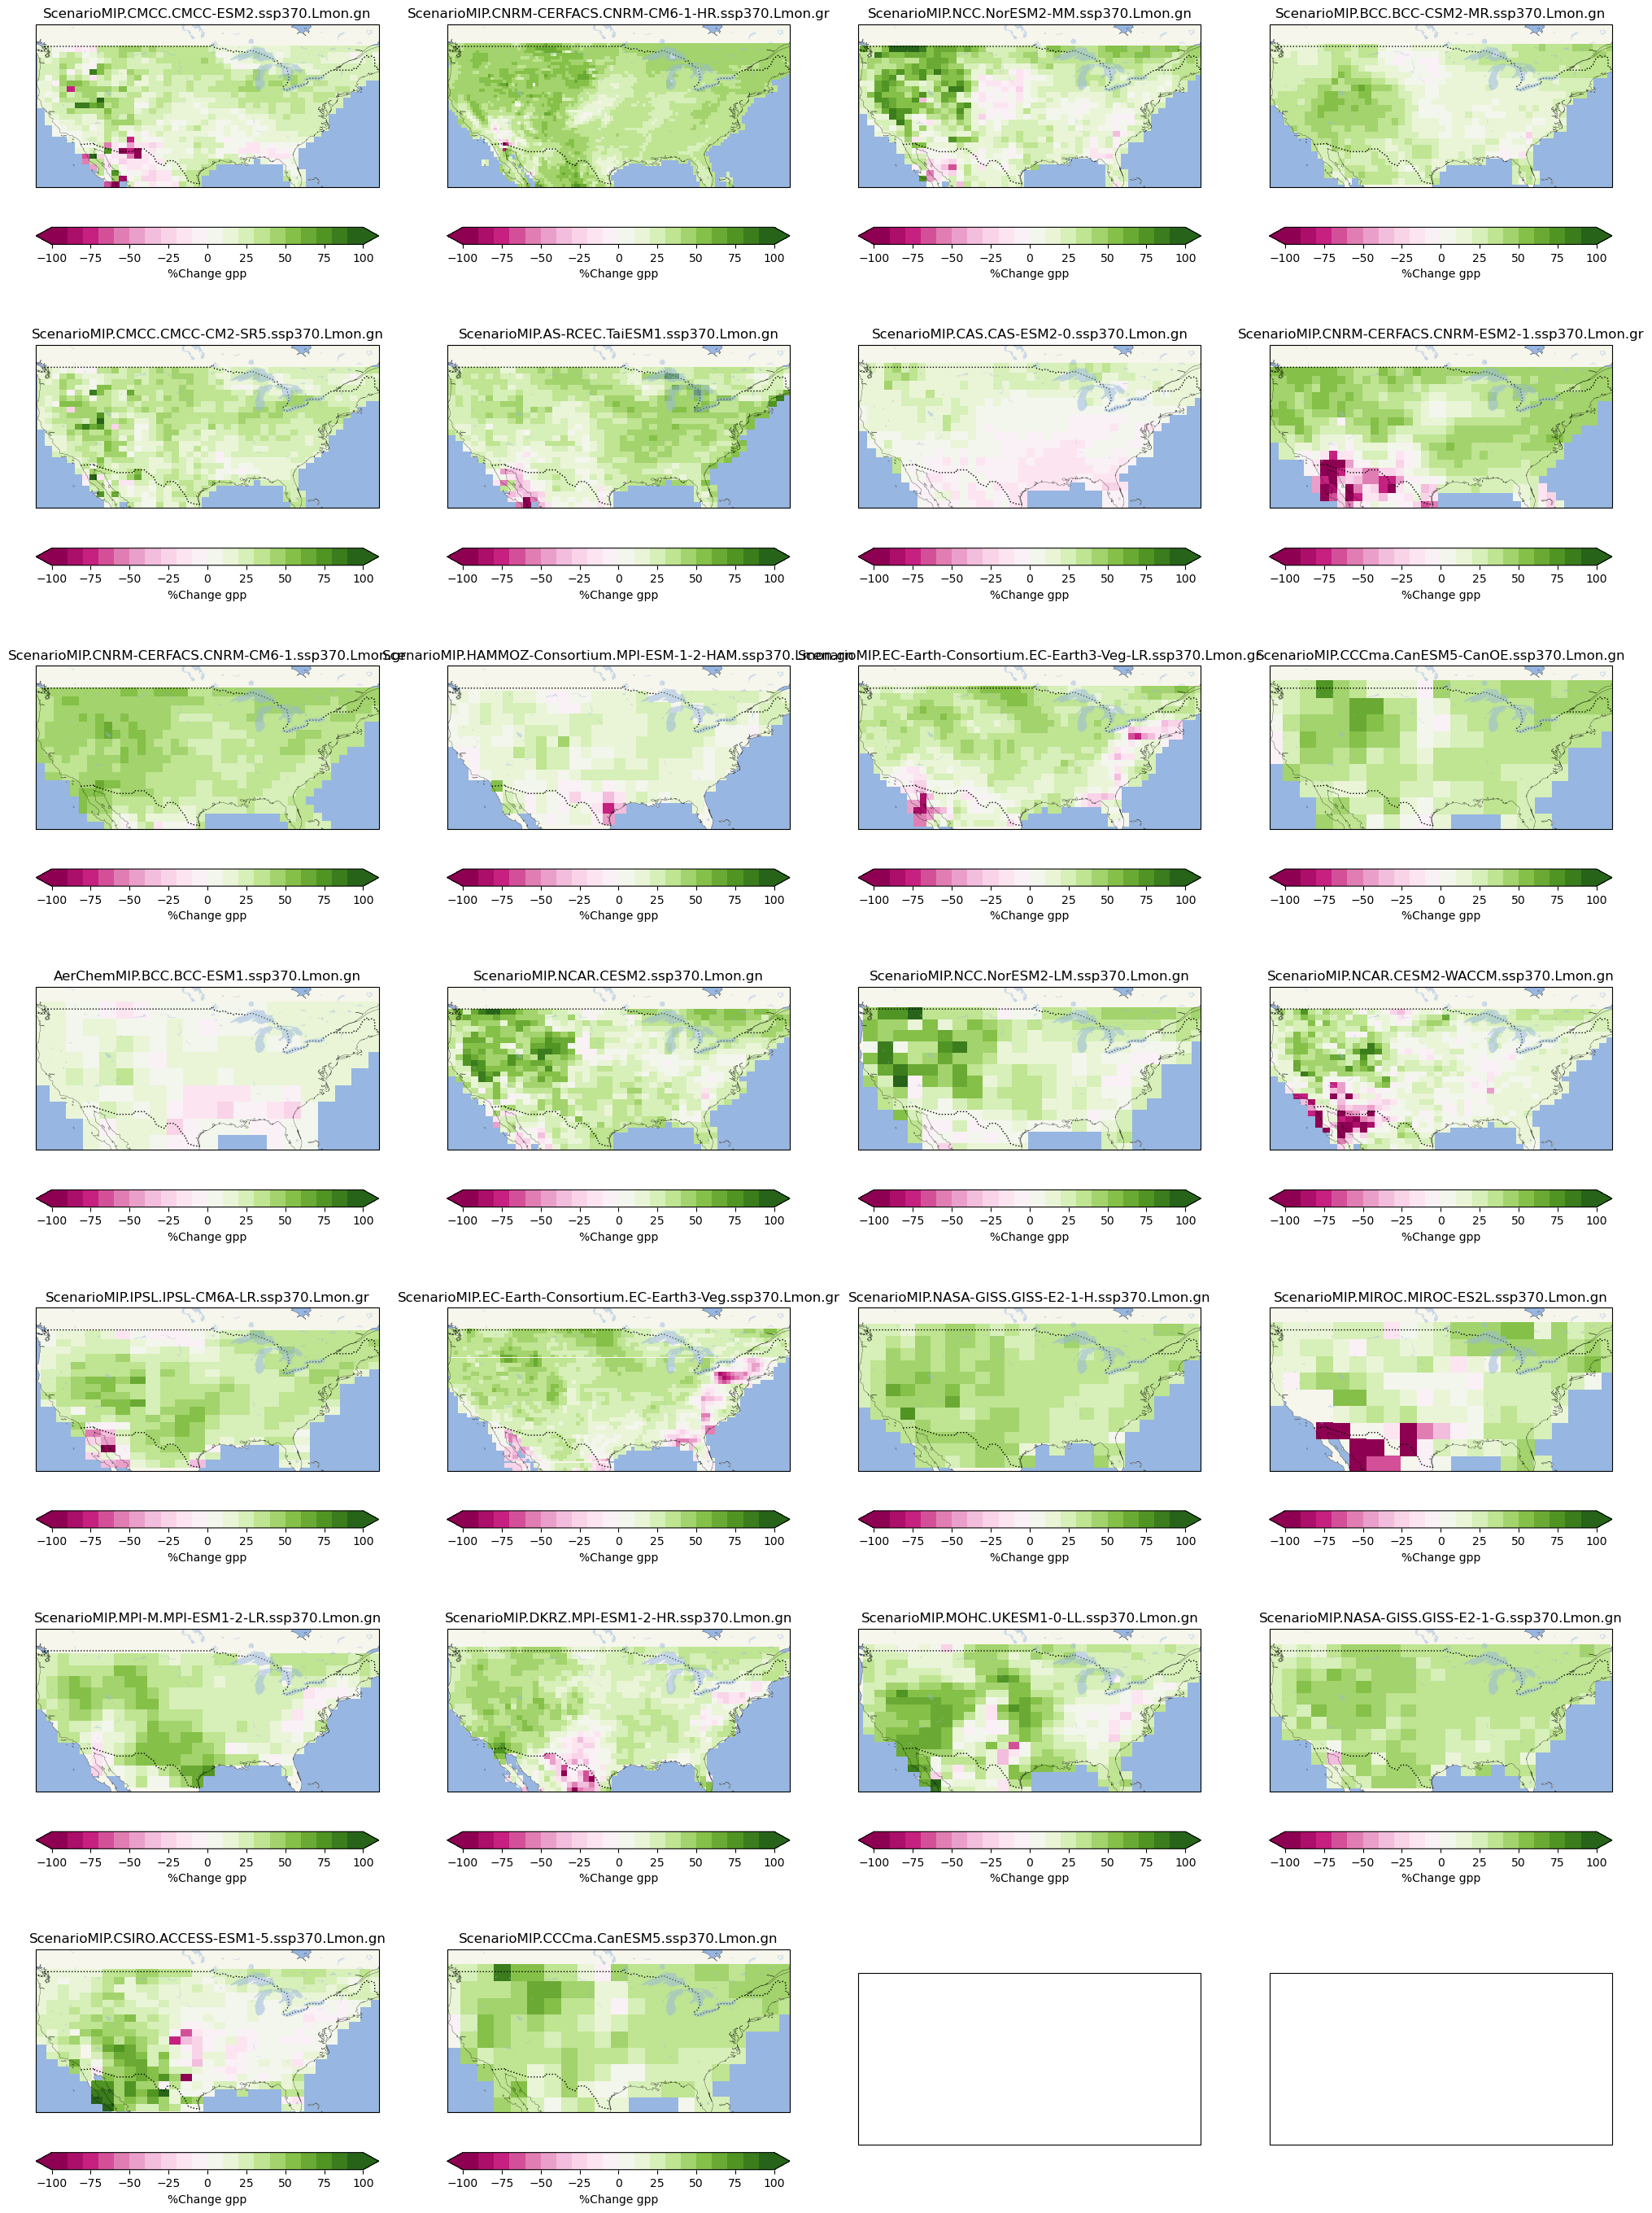

In [7]:
%%capture --no-display
#create figure and axes handles - plot percent change in GPP

projection = ccrs.PlateCarree()
subplot_kw = dict(projection=ccrs.PlateCarree())

cmap = matplotlib.colormaps.get_cmap('PiYG').resampled(20)
fig, axarr = plt.subplots(nrows=7, ncols=4, figsize=[25,35],subplot_kw=subplot_kw)
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    
    if "dcpp_init_year" in ds.dims:
        ds = ds.drop('dcpp_init_year')
    
    if k == 'ScenarioMIP.IPSL.IPSL-CM5A2-INCA.ssp370.Lmon.gr':
        tmplon = ds['lon'].values
        tmplon[0] = 0
        ds['lon'] = tmplon
    
    da = ds[varload].isel(time=slice(0,1020)).coarsen(time=12,boundary='exact').mean()#.squeeze()
    da = da.where(da > 0)
    da = da.sel(lat=slice(latbound[0],latbound[1])).sel(lon=slice(lonbound[0]+360,lonbound[1]+360))
    
    da_t0 = da.isel(time=slice(0,5)).mean('time')
    da_tend = da.isel(time=slice(-5,-1)).mean('time')
    
    da_dlta_perc = (da_tend - da_t0)/da_tend * 100
    
    ax.set_title(k)

    try:
        pltdata = da_dlta_perc
        vlim = [-100,100] #dsplt.quantile(quant_bound).values
        
        latp, lonp = latlon_latlonpcolor(pltdata.lat.values,pltdata.lon.values)
        
        
        lons, lats = np.meshgrid(lonp,latp)
        
        #create masked array where nan=mask. pcolormesh does not like NaNs.
        data_mask = np.ma.masked_where(np.isnan(pltdata.squeeze()),pltdata.squeeze())
        
        
        
        import cartopy.feature as cfeature
        ax.add_feature(cfeature.LAND,alpha=0.5)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE,linewidth=0.2)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        #ax.add_feature(cfeature.RIVERS)
        
        
        ax.set_extent([lonbound[1],lonbound[0],latbound[0],latbound[1]])
        
        
        
        im1 = ax.pcolor(lons,lats,data_mask,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vlim[0],vmax=vlim[1])
        
        cb = plt.colorbar(im1,ax=ax,orientation = 'horizontal',extend='both')
        cb.set_label('%Change {}'.format(varload))
    
    except:
        print(k)
        ax.axis('off')
        pass

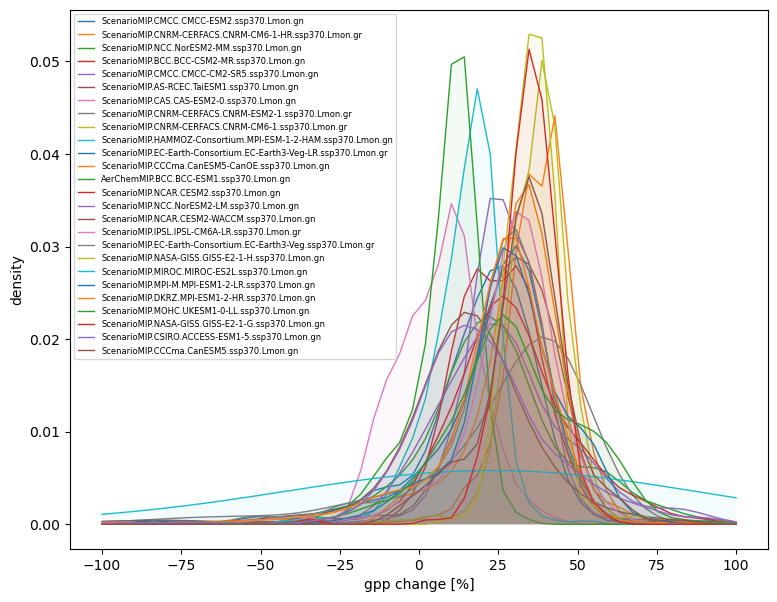

In [8]:
%%capture --no-display
#%% Plot distributions of leaf area change



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9,7])
for k, ds in list(dset_dict.items())[0:]:
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    
    if "dcpp_init_year" in ds.dims:
        ds = ds.drop('dcpp_init_year').squeeze()
    
    if k == 'ScenarioMIP.IPSL.IPSL-CM5A2-INCA.ssp370.Lmon.gr':
        tmplon = ds['lon'].values
        tmplon[0] = 0
        ds['lon'] = tmplon
    
    da = ds[varload].isel(time=slice(0,1020)).coarsen(time=12,boundary='exact').mean()#.squeeze()
    da = da.where(da > 0)
    da = da.sel(lat=slice(latbound[0],latbound[1])).sel(lon=slice(lonbound[0]+360,lonbound[1]+360))
    
    #
    ## Select the first five years and last five years
    da_t0 = da.isel(time=slice(0,5)).mean('time')
    da_tend = da.isel(time=slice(-5,-1)).mean('time')
    
    #
    ## Calculate the percent change
    da_dlta_perc = (da_tend - da_t0)/da_tend * 100
    
    range_here = [-100,100]
    bins = 50
    
    pltdata = da_dlta_perc
    pltdata_vec_wn = pltdata.values.flatten()
    nnmask = ~np.isnan(pltdata_vec_wn)
    nninf = np.abs(pltdata_vec_wn) != np.inf
    pltdata_vec = pltdata_vec_wn[nnmask*nninf]
    # Calculate the density plot
    density = gaussian_kde(pltdata_vec)
    xplt = np.linspace(range_here[0],range_here[1],bins)
    yplt=density(xplt)

    # Plot the histogram and density
    
    ax.fill_between(xplt, yplt,alpha=0.05,zorder=2,label='__nolabel__')
    ax.plot(xplt, yplt,alpha=1,linewidth=1,label=k,zorder=2)
    
    ax.set_ylabel('density')
    ax.set_xlabel('{} change [%]'.format(varload))
    ax.legend(fontsize=6)